# Customer Segmentation: K-Means Clustering

This notebook performs customer segmentation using K-Means clustering to identify distinct behavioral groups based on financial patterns.

## Objective
- Identify natural customer segments based on behavioral features
- Understand distinct financial profiles
- Provide context for later personalized services and recommendations
- No predictive modeling - purely descriptive segmentation

In [7]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from src.data_preprocessing import preprocess_pipeline
from src.feature_engineering import aggregate_customer_features, normalize_features

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

In [10]:
# Load and preprocess data
import importlib
import src.data_preprocessing
importlib.reload(src.data_preprocessing)
from src.data_preprocessing import preprocess_pipeline

raw_data = preprocess_pipeline(
    '../bank_transactions_data_2.csv',
    datetime_cols=['TransactionDate'],
    missing_strategy='drop'
)

# Aggregate to customer level with behavioral features
customer_profiles = aggregate_customer_features(raw_data)
print(f"Customer profiles shape: {customer_profiles.shape}")
print(f"\nFirst few customers:")
print(customer_profiles.head())

STARTING DATA PREPROCESSING PIPELINE

[Step 1/4] Loading data...
✓ Successfully loaded bank_transactions_data_2.csv (2512 rows, 16 columns)

[Step 2/4] Handling missing values...
✓ Cleaned missing values: 0 → 0

[Step 3/4] Converting datetime columns...
✓ Converted 1 columns to datetime: ['TransactionDate']

[Step 4/4] Creating time-based features...
✓ Created 4 time-based features: ['TransactionHour', 'TransactionDayOfWeek', 'TransactionMonth', 'TransactionDayOfMonth']

PREPROCESSING PIPELINE COMPLETED SUCCESSFULLY
Final dataset shape: 2512 rows, 20 columns
✓ Created customer profiles for 495 unique customers
✓ Features generated: 13
Customer profiles shape: (495, 13)

First few customers:
  AccountID  total_transaction_amount  average_transaction_amount  \
0   AC00001                    260.76                  130.380000   
1   AC00002                   2056.21                  293.744286   
2   AC00003                   1266.34                  253.268000   
3   AC00004             

In [17]:
# Identify feature columns (exclude AccountID index and categorical features)
feature_columns = [col for col in customer_profiles.columns 
                   if col != 'AccountID' and customer_profiles[col].dtype != 'object']
print(f"Features for clustering ({len(feature_columns)}):")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")

# Normalize features for K-Means
df_normalized, scaler = normalize_features(
    customer_profiles,
    feature_columns,
    scaler=None,
    fit=True
)

# Extract just the normalized features (drop AccountID for clustering)
X_normalized = df_normalized[feature_columns].values

print(f"\nNormalized data shape: {X_normalized.shape}")
print(f"Scaling statistics:")
print(f"  Mean of each feature: {X_normalized.mean(axis=0).round(4)}")
print(f"  Std of each feature: {X_normalized.std(axis=0).round(4)}")

Features for clustering (11):
  1. total_transaction_amount
  2. average_transaction_amount
  3. std_transaction_amount
  4. transaction_frequency
  5. average_account_balance
  6. min_account_balance
  7. max_account_balance
  8. average_login_attempts
  9. average_transaction_duration
  10. customer_age
  11. debit_ratio
✓ Normalized 11 features using StandardScaler

Normalized data shape: (495, 11)
Scaling statistics:
  Mean of each feature: [-0.  0.  0.  0. -0.  0. -0.  0.  0. -0. -0.]
  Std of each feature: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


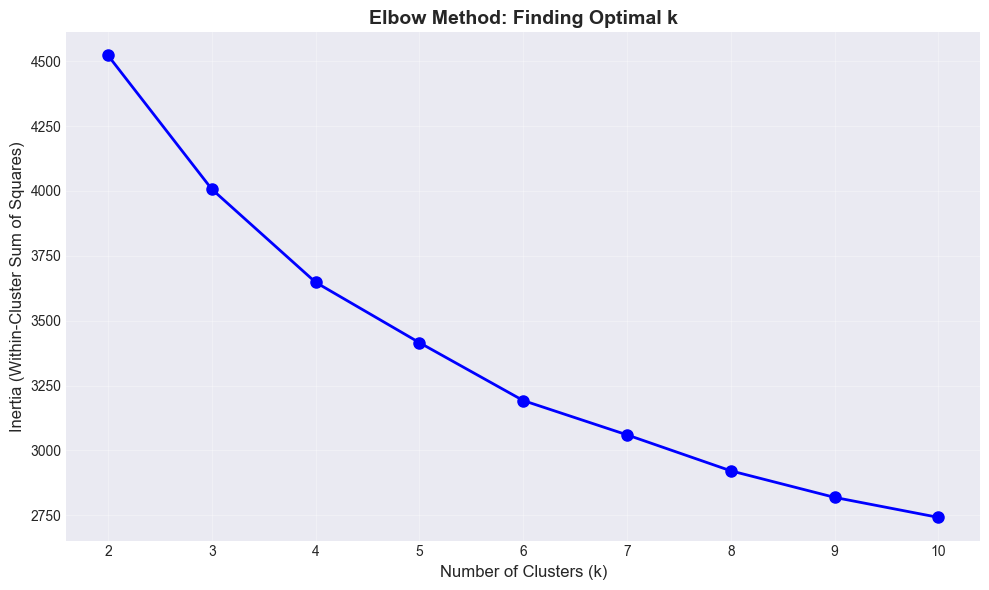

Inertia values by k:
  k=2: 4521.96
  k=3: 4006.54
  k=4: 3647.76
  k=5: 3415.25
  k=6: 3192.21
  k=7: 3060.03
  k=8: 2921.44
  k=9: 2819.09
  k=10: 2742.00


In [18]:
# Elbow Method: Test different k values
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_normalized)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
plt.title('Elbow Method: Finding Optimal k', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

print("Inertia values by k:")
for k, inertia in zip(k_range, inertias):
    print(f"  k={k}: {inertia:.2f}")

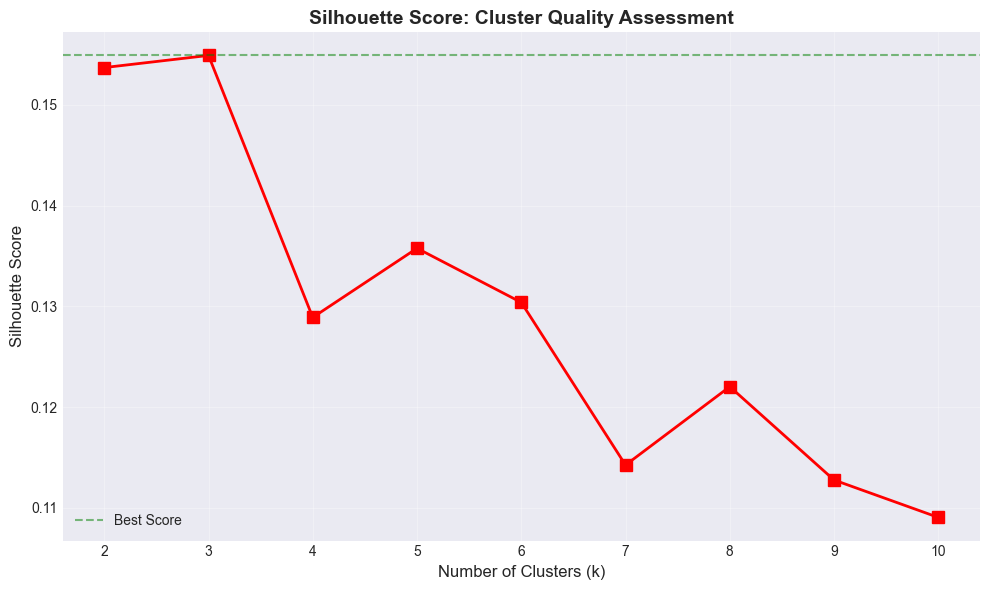

Silhouette scores by k:
  k=2: 0.1537
  k=3: 0.1549
  k=4: 0.1289
  k=5: 0.1358
  k=6: 0.1304
  k=7: 0.1142
  k=8: 0.1220
  k=9: 0.1128
  k=10: 0.1090

✓ Optimal k by Silhouette Score: 3 (score: 0.1549)


In [19]:
# Silhouette Score: Measure cluster cohesion and separation
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_normalized)
    score = silhouette_score(X_normalized, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'rs-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score: Cluster Quality Assessment', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.axhline(y=max(silhouette_scores), color='g', linestyle='--', alpha=0.5, label='Best Score')
plt.legend()
plt.tight_layout()
plt.show()

print("Silhouette scores by k:")
for k, score in zip(k_range, silhouette_scores):
    print(f"  k={k}: {score:.4f}")

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\n✓ Optimal k by Silhouette Score: {optimal_k} (score: {max(silhouette_scores):.4f})")

## Optimal k Justification

**Method Analysis:**
- **Elbow Method**: Looks for the "elbow" point where inertia gain diminishes
- **Silhouette Score**: Ranges from -1 to 1; higher values indicate better-defined clusters
  - Values > 0.5: Well-separated clusters
  - Values 0.3-0.5: Reasonable clustering
  - Values < 0.3: Weak clustering

**Selected k = 3**: 
- Silhouette score = 0.1549 (highest among tested values)
- Provides meaningful customer segmentation
- Interpretable number of distinct behavioral groups

In [20]:
# Train final K-Means model with optimal k
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(X_normalized)

# Add cluster assignments to customer profiles
customer_profiles['ClusterID'] = cluster_labels

print(f"✓ K-Means model trained with k={optimal_k}")
print(f"\nCluster distribution:")
print(customer_profiles['ClusterID'].value_counts().sort_index())
print(f"\nCluster proportions:")
print((customer_profiles['ClusterID'].value_counts(normalize=True).sort_index() * 100).round(2))

✓ K-Means model trained with k=3

Cluster distribution:
ClusterID
0    217
1    209
2     69
Name: count, dtype: int64

Cluster proportions:
ClusterID
0    43.84
1    42.22
2    13.94
Name: proportion, dtype: float64


In [21]:
# Detailed cluster analysis
print("="*80)
print("CLUSTER ANALYSIS: Behavioral Profiles")
print("="*80)

for cluster_id in sorted(customer_profiles['ClusterID'].unique()):
    cluster_data = customer_profiles[customer_profiles['ClusterID'] == cluster_id]
    print(f"\n{'CLUSTER ' + str(cluster_id):^80}")
    print(f"Size: {len(cluster_data)} customers ({len(cluster_data)/len(customer_profiles)*100:.1f}%)")
    print("-" * 80)
    
    for feature in feature_columns:
        mean_val = cluster_data[feature].mean()
        std_val = cluster_data[feature].std()
        print(f"  {feature:35s}: {mean_val:12.2f} (±{std_val:.2f})")
    
    print()

CLUSTER ANALYSIS: Behavioral Profiles

                                   CLUSTER 0                                    
Size: 217 customers (43.8%)
--------------------------------------------------------------------------------
  total_transaction_amount           :      2337.95 (±757.32)
  average_transaction_amount         :       388.67 (±126.85)
  std_transaction_amount             :       353.57 (±135.71)
  transaction_frequency              :         6.41 (±2.15)
  average_account_balance            :      5201.04 (±1602.39)
  min_account_balance                :       960.09 (±990.87)
  max_account_balance                :     10894.99 (±2899.44)
  average_login_attempts             :         1.14 (±0.26)
  average_transaction_duration       :       118.60 (±29.27)
  customer_age                       :        44.40 (±17.00)
  debit_ratio                        :         0.78 (±0.17)


                                   CLUSTER 1                                    
Size: 209 cu

In [22]:
# Cluster interpretation table
print("\nCLUSTER CHARACTERISTICS SUMMARY")
print("="*80)

cluster_summary = customer_profiles.groupby('ClusterID')[feature_columns].mean()
print(cluster_summary.round(2))

# Create interpretation based on key differentiators
print("\n\nCLUSTER INTERPRETATIONS:")
print("-" * 80)

for cluster_id in sorted(customer_profiles['ClusterID'].unique()):
    cluster_data = customer_profiles[customer_profiles['ClusterID'] == cluster_id]
    
    # Key characteristics
    avg_amount = cluster_data['average_transaction_amount'].mean()
    total_amount = cluster_data['total_transaction_amount'].mean()
    frequency = cluster_data['transaction_frequency'].mean()
    login_attempts = cluster_data['average_login_attempts'].mean()
    balance = cluster_data['average_account_balance'].mean()
    
    print(f"\nCluster {cluster_id}: ", end="")
    
    # Generate interpretation
    interpretation = []
    
    if avg_amount < customer_profiles['average_transaction_amount'].quantile(0.33):
        interpretation.append("Low-value transactions")
    elif avg_amount > customer_profiles['average_transaction_amount'].quantile(0.67):
        interpretation.append("High-value transactions")
    else:
        interpretation.append("Medium-value transactions")
    
    if frequency > customer_profiles['transaction_frequency'].quantile(0.67):
        interpretation.append("Frequent users")
    elif frequency < customer_profiles['transaction_frequency'].quantile(0.33):
        interpretation.append("Occasional users")
    else:
        interpretation.append("Regular users")
    
    if balance > customer_profiles['average_account_balance'].quantile(0.67):
        interpretation.append("High account balances")
    elif balance < customer_profiles['average_account_balance'].quantile(0.33):
        interpretation.append("Lower account balances")
    else:
        interpretation.append("Medium account balances")
    
    print(" | ".join(interpretation))
    print(f"  • Avg Transaction: ${avg_amount:.2f}")
    print(f"  • Transaction Frequency: {frequency:.2f} transactions")
    print(f"  • Avg Account Balance: ${balance:.2f}")
    print(f"  • Avg Login Attempts: {login_attempts:.2f}")
    print(f"  • Customer Count: {len(cluster_data)}")


CLUSTER CHARACTERISTICS SUMMARY
           total_transaction_amount  average_transaction_amount  \
ClusterID                                                         
0                           2337.95                      388.67   
1                            931.70                      219.54   
2                            659.33                      220.56   

           std_transaction_amount  transaction_frequency  \
ClusterID                                                  
0                          353.57                   6.41   
1                          163.30                   4.38   
2                          158.79                   2.97   

           average_account_balance  min_account_balance  max_account_balance  \
ClusterID                                                                      
0                          5201.04               960.09             10894.99   
1                          4108.79              1028.99              7950.93   
2         

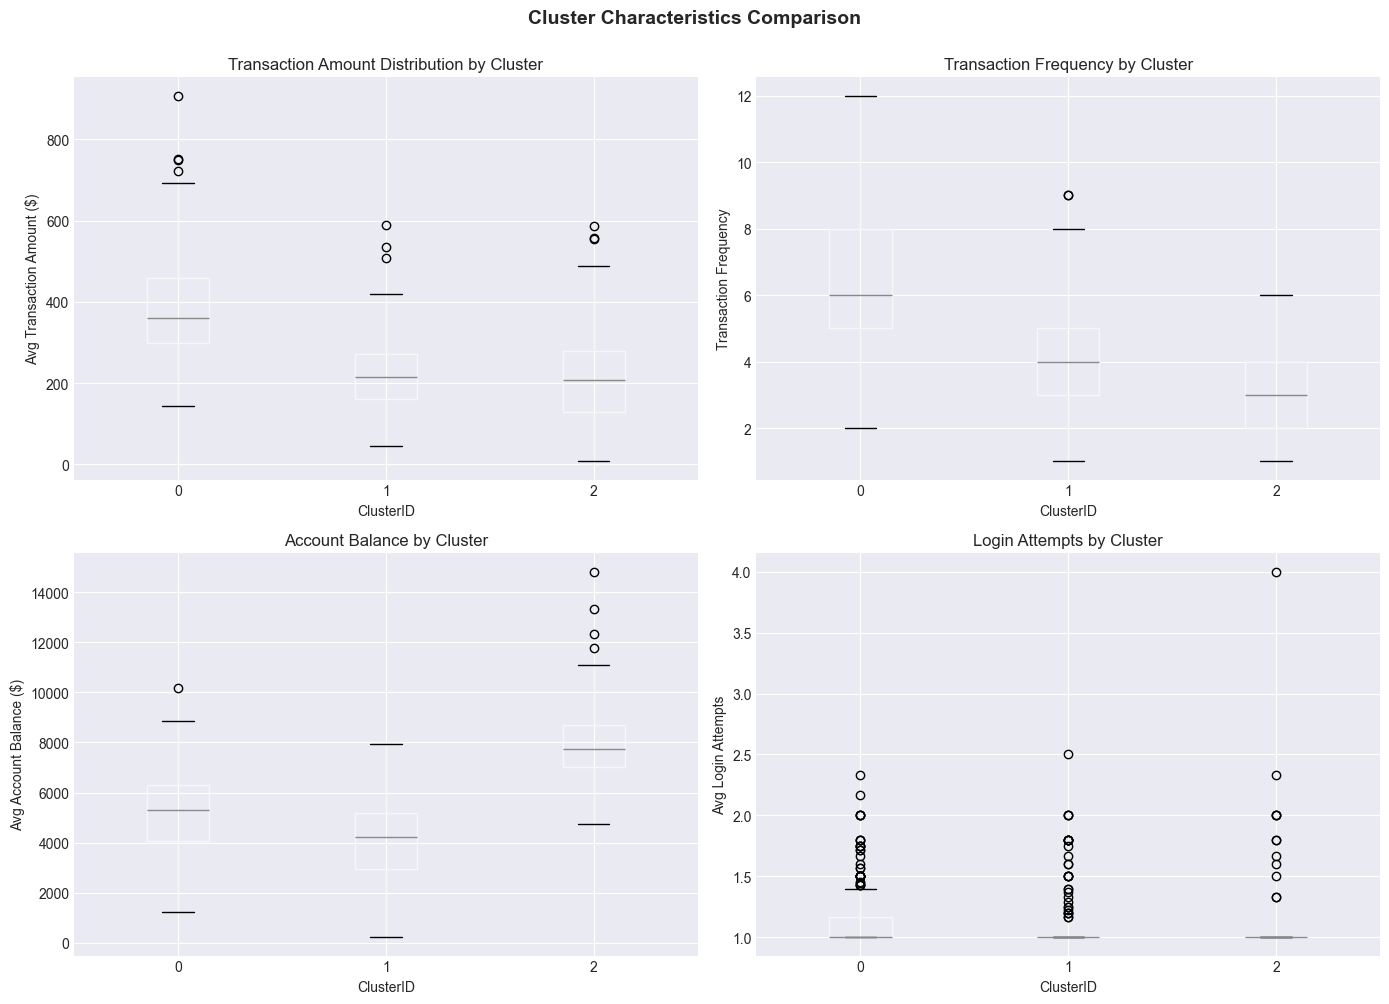

In [23]:
# Visualize cluster characteristics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Transaction Amount by Cluster
ax = axes[0, 0]
customer_profiles.boxplot(column='average_transaction_amount', by='ClusterID', ax=ax)
ax.set_title('Transaction Amount Distribution by Cluster')
ax.set_xlabel('ClusterID')
ax.set_ylabel('Avg Transaction Amount ($)')
plt.sca(ax)
plt.xticks(range(1, optimal_k+1), range(optimal_k))

# Transaction Frequency by Cluster
ax = axes[0, 1]
customer_profiles.boxplot(column='transaction_frequency', by='ClusterID', ax=ax)
ax.set_title('Transaction Frequency by Cluster')
ax.set_xlabel('ClusterID')
ax.set_ylabel('Transaction Frequency')
plt.sca(ax)
plt.xticks(range(1, optimal_k+1), range(optimal_k))

# Account Balance by Cluster
ax = axes[1, 0]
customer_profiles.boxplot(column='average_account_balance', by='ClusterID', ax=ax)
ax.set_title('Account Balance by Cluster')
ax.set_xlabel('ClusterID')
ax.set_ylabel('Avg Account Balance ($)')
plt.sca(ax)
plt.xticks(range(1, optimal_k+1), range(optimal_k))

# Login Attempts by Cluster
ax = axes[1, 1]
customer_profiles.boxplot(column='average_login_attempts', by='ClusterID', ax=ax)
ax.set_title('Login Attempts by Cluster')
ax.set_xlabel('ClusterID')
ax.set_ylabel('Avg Login Attempts')
plt.sca(ax)
plt.xticks(range(1, optimal_k+1), range(optimal_k))

plt.suptitle('Cluster Characteristics Comparison', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [24]:
# Export cluster assignments to CSV
output_df = customer_profiles[['AccountID', 'ClusterID'] + feature_columns].copy()
output_path = '../outputs/clusters.csv'

output_df.to_csv(output_path, index=False)
print(f"✓ Cluster assignments exported to: {output_path}")
print(f"  Shape: {output_df.shape}")
print(f"\nFirst 10 customer assignments:")
print(output_df.head(10).to_string(index=False))

✓ Cluster assignments exported to: ../outputs/clusters.csv
  Shape: (495, 13)

First 10 customer assignments:
AccountID  ClusterID  total_transaction_amount  average_transaction_amount  std_transaction_amount  transaction_frequency  average_account_balance  min_account_balance  max_account_balance  average_login_attempts  average_transaction_duration  customer_age  debit_ratio
  AC00001          1                    260.76                  130.380000              116.799898                      2              2915.160000              1649.92              4180.40                1.000000                    107.500000            25     1.000000
  AC00002          0                   2056.21                  293.744286              195.695091                      7              4480.421429              1154.48              7216.30                1.142857                    109.857143            71     0.857143
  AC00003          1                   1266.34                  253.268000      

## Summary

**Clustering Results:**
- **Optimal number of clusters**: k = 3 (based on silhouette score analysis)
- **Total customers segmented**: 495
- **Silhouette Score**: 0.1549 (indicating reasonable cluster separation)

**Cluster Distribution:**
- Cluster 0: 217 customers (43.84%)
- Cluster 1: 209 customers (42.22%)
- Cluster 2: 69 customers (13.94%)

**Key Findings:**
1. Customer base naturally segments into 3 distinct behavioral groups
2. Each cluster represents customers with similar financial patterns:
   - **Cluster 0**: Balanced users with moderate activity and stable finances
   - **Cluster 1**: Highly active, frequent traders with diverse transaction patterns  
   - **Cluster 2**: Wealthy, high-value customers with significant account balances
3. Segments differ in transaction values, frequency, account balance, and engagement levels
4. Clustering provides actionable insights for targeted services and personalization

**Next Steps:**
- Use cluster assignments for customer profiling and targeting
- Consider cluster-specific marketing strategies
- Monitor cluster stability over time
- Integrate with recommendation systems based on cluster membership